In [2]:
import numpy as np
import patsy

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

# Generate B-spline bases with Scipy
# https://stackoverflow.com/questions/61807542/generate-a-b-spline-basis-in-scipy-like-bs-in-r

In [67]:
n = 128
order = 3
kleft = 2 # must be even
kright = 4
k = kleft + kright
std = 0.3

# the problem has k + order + 1 degrees of freedom
# and hence, k + order + 1 bases
btrue = np.array([1.3, 4.5, -1.9, 10.4, 0.6, 6.7, 0.6, 6.7, 2.6])

xmin = 0
xmax = 1
xsep = 0.7
x = np.linspace(xmin, xmax, n)
left_knots = np.linspace(xmin, xsep, kleft+2)[1:-1]
right_knots = np.linspace(xsep, xmax, kright+1)[:-1]
knots = np.concatenate((left_knots, right_knots))
bspline_bases = patsy.bs(x, knots = knots, degree = order, include_intercept=False)
#bspline_bases = patsy.bs(x, df = k + order + 1, degree = order, include_intercept = 1)


y = np.dot(bspline_bases, btrue) + np.random.normal(0, std, size = n)
#y -= np.min(y)

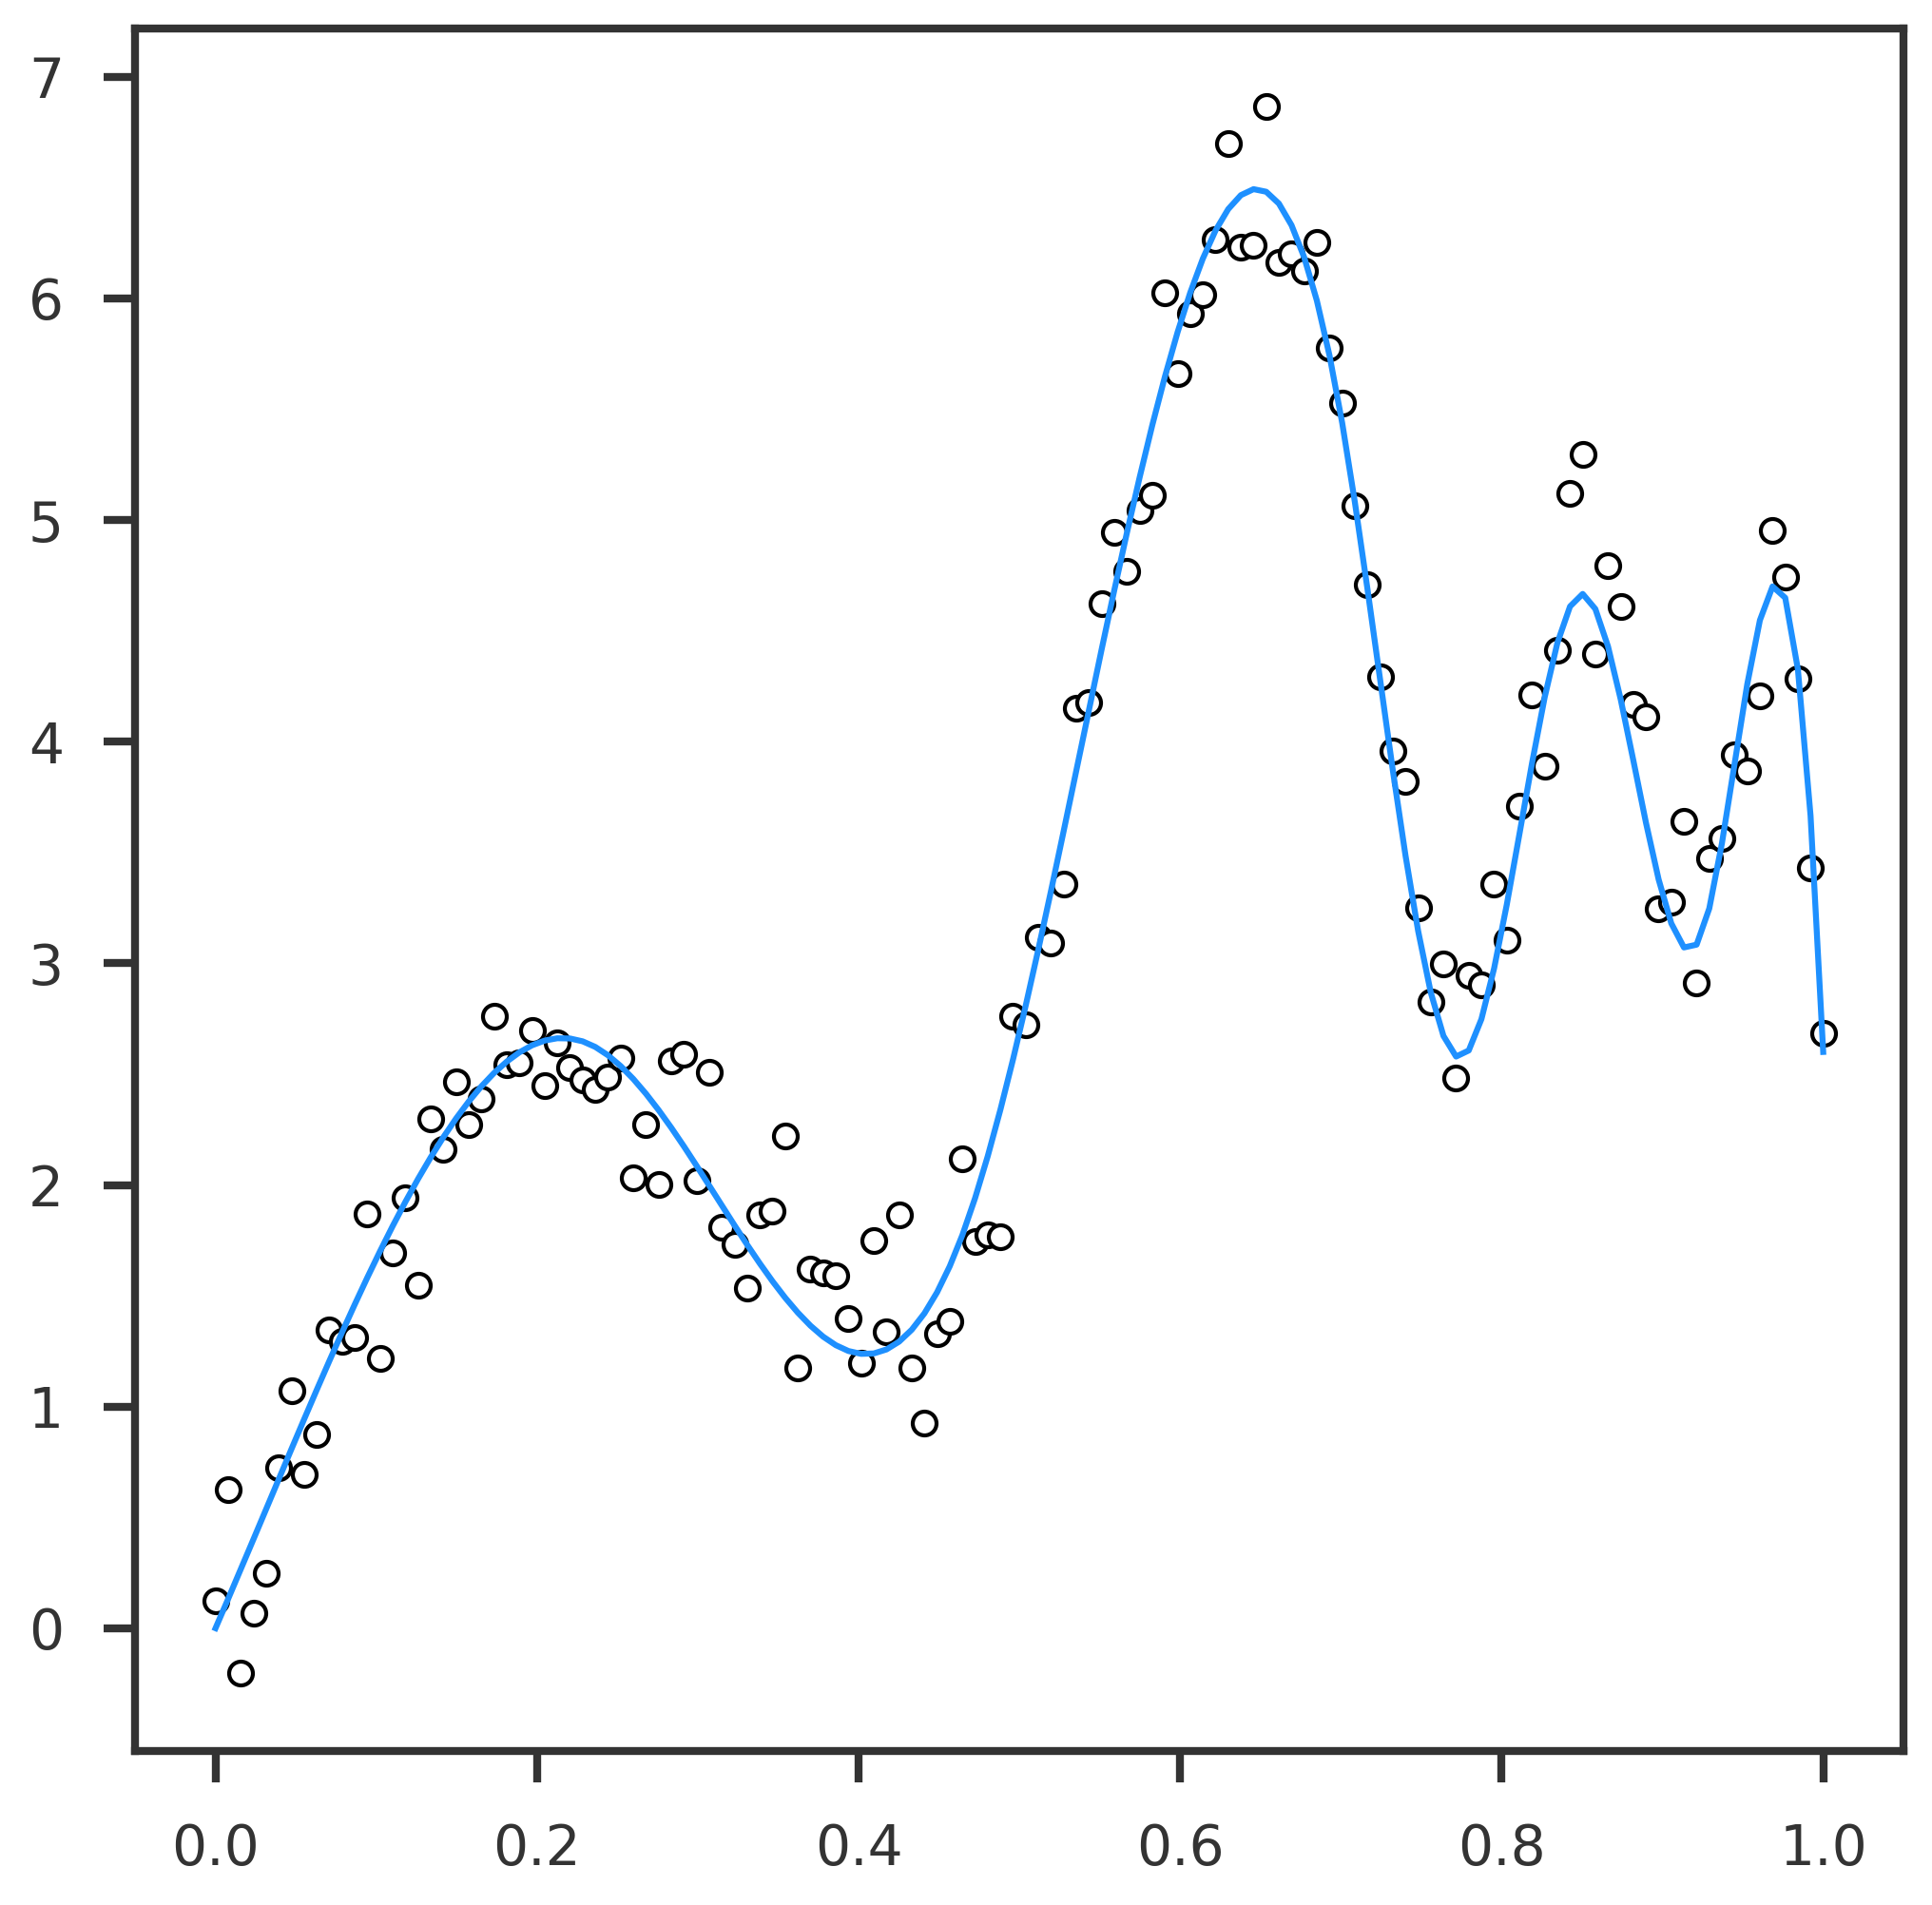

In [68]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, edgecolor = 'black', facecolor = 'white')
ax1.plot(x, np.dot(bspline_bases, btrue), color = 'dodgerblue')
#ax1.plot(x, bspline_bases * btrue, alpha = 0.1)
plt.show()

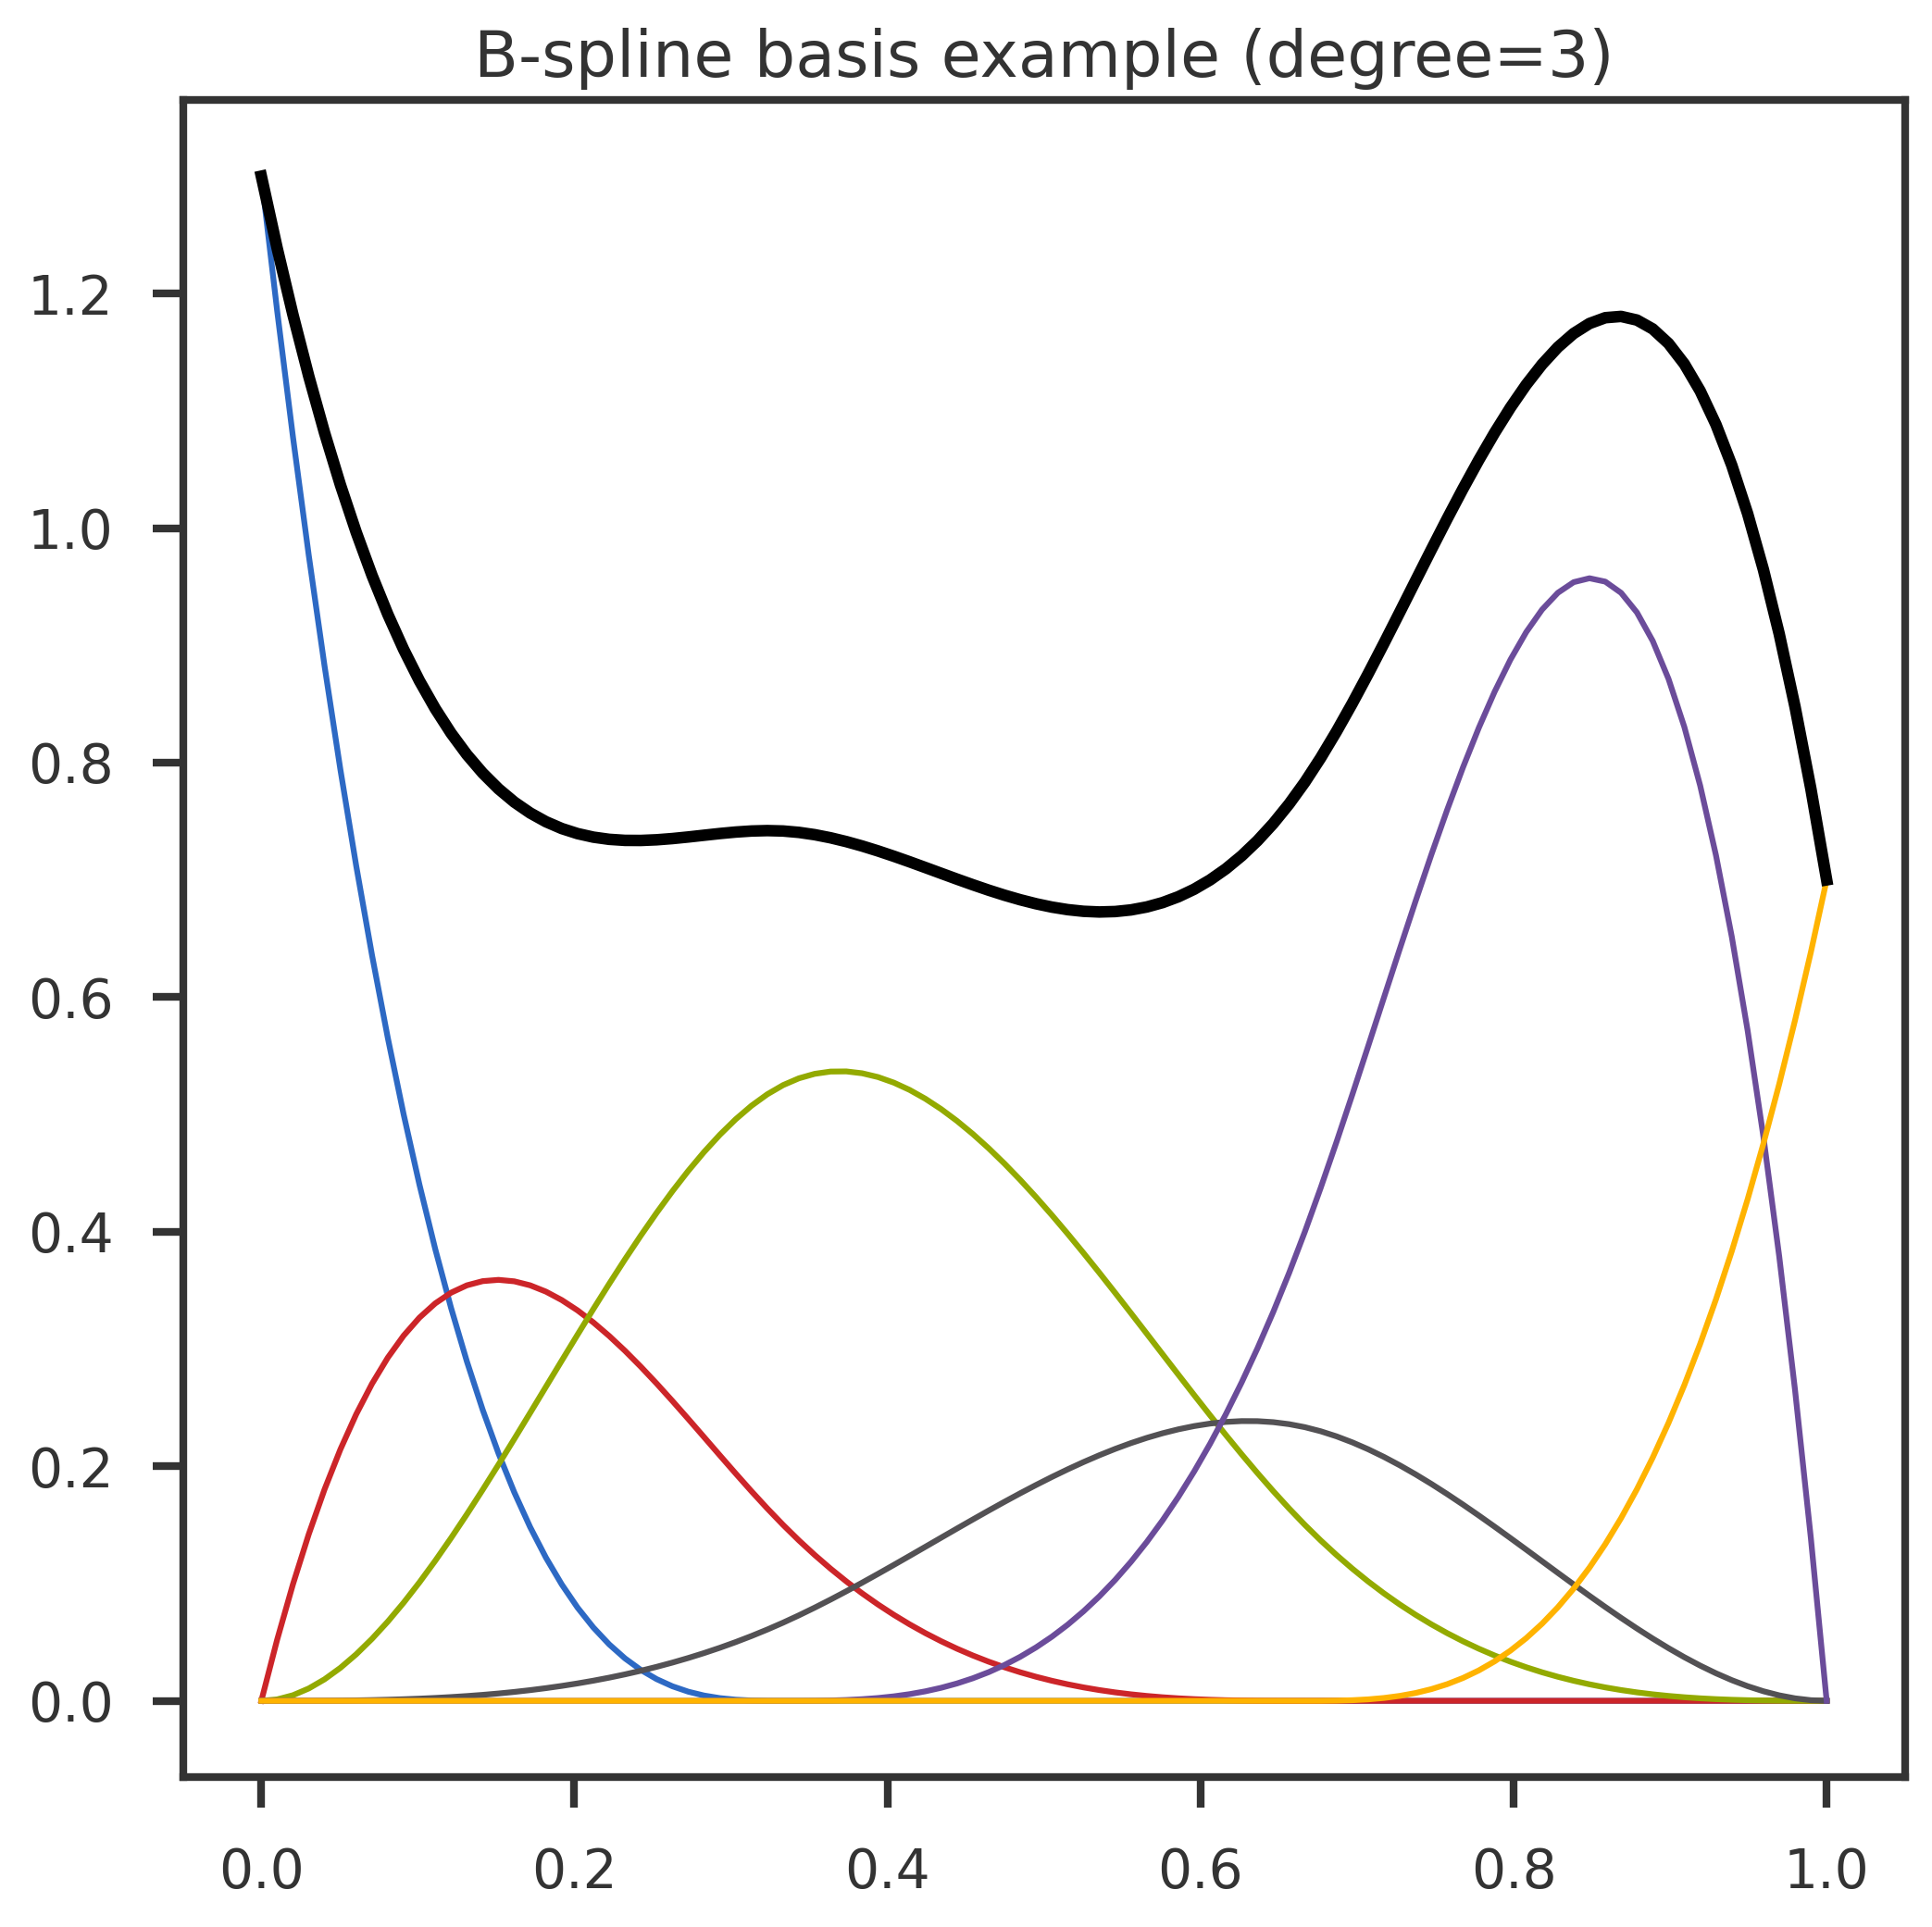

In [76]:
import matplotlib.pyplot as plt

plt.title("B-spline basis example (degree=3)");

x = np.linspace(0., 1., 100)

y = patsy.dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": x})

# Define some coefficients
b = np.array([1.3, 0.6, 0.9, 0.4, 1.6, 0.7])

# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.plot(x, y*b);

# Plot the spline itself (sum of the basis functions, thick black curve)
plt.plot(x, np.dot(y, b), color='k', linewidth=3);

In [78]:
patsy.dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": x}) - 1

array([[ 0.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-0.0881821 , -0.91317444, -0.9986481 , -0.99999536, -1.        ,
        -1.        ],
       [-0.17102151, -0.83432117, -0.99469442, -0.9999629 , -1.        ,
        -1.        ],
       [-0.2486852 , -0.76314801, -0.98829201, -0.99987478, -1.        ,
        -1.        ],
       [-0.32134012, -0.69936277, -0.97959392, -0.99970318, -1.        ,
        -1.        ],
       [-0.38915324, -0.64267329, -0.96875319, -0.99942028, -1.        ,
        -1.        ],
       [-0.45229151, -0.59278738, -0.95592287, -0.99899825, -1.        ,
        -1.        ],
       [-0.51092189, -0.54941286, -0.94125599, -0.99840925, -1.        ,
        -1.        ],
       [-0.56521134, -0.51225756, -0.92490562, -0.99762547, -1.        ,
        -1.        ],
       [-0.61532682, -0.4810293 , -0.90702479, -0.99661908, -1.        ,
        -1.        ],
       [-0.66143529, -0.4554359 , -0.88776655, -0.

In [80]:
patsy.bs(x, df=6, degree=3, include_intercept=True) - 1

array([[ 0.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-0.0881821 , -0.91317444, -0.9986481 , -0.99999536, -1.        ,
        -1.        ],
       [-0.17102151, -0.83432117, -0.99469442, -0.9999629 , -1.        ,
        -1.        ],
       [-0.2486852 , -0.76314801, -0.98829201, -0.99987478, -1.        ,
        -1.        ],
       [-0.32134012, -0.69936277, -0.97959392, -0.99970318, -1.        ,
        -1.        ],
       [-0.38915324, -0.64267329, -0.96875319, -0.99942028, -1.        ,
        -1.        ],
       [-0.45229151, -0.59278738, -0.95592287, -0.99899825, -1.        ,
        -1.        ],
       [-0.51092189, -0.54941286, -0.94125599, -0.99840925, -1.        ,
        -1.        ],
       [-0.56521134, -0.51225756, -0.92490562, -0.99762547, -1.        ,
        -1.        ],
       [-0.61532682, -0.4810293 , -0.90702479, -0.99661908, -1.        ,
        -1.        ],
       [-0.66143529, -0.4554359 , -0.88776655, -0.

In [35]:
btrue

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [22]:
bspline_bases.shape

(128, 15)

In [9]:
right_knots

array([0.7, 0.8, 0.9, 1. ])

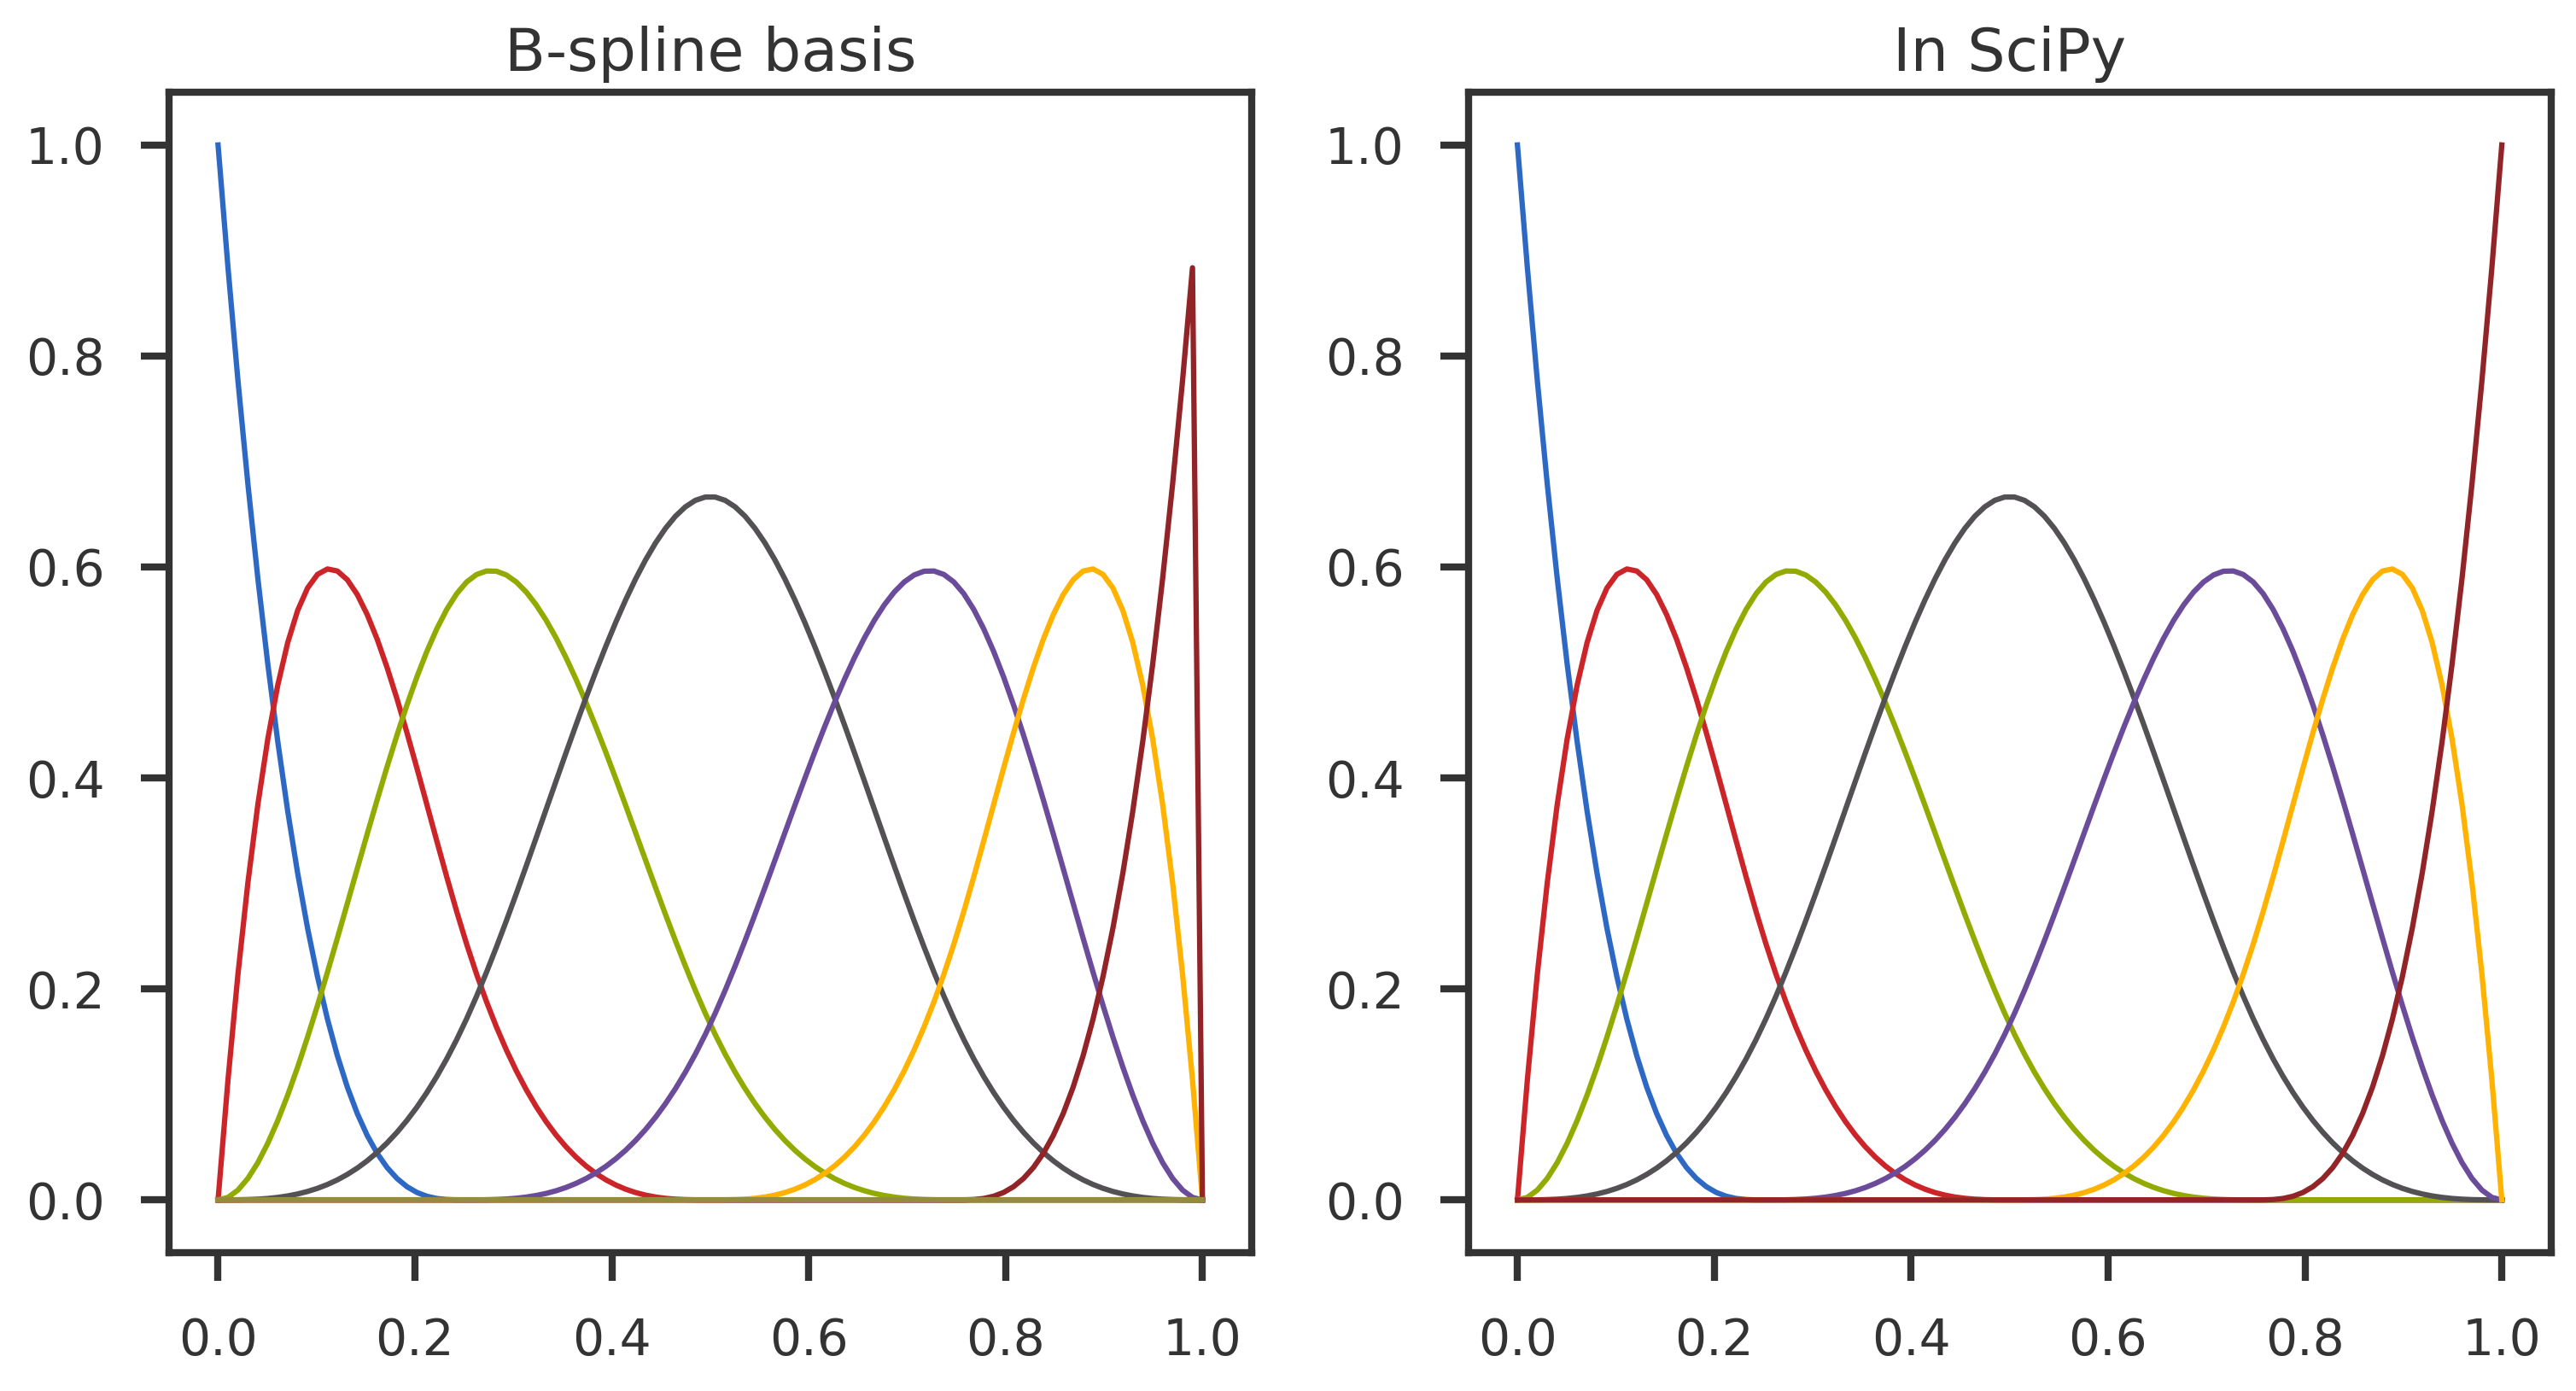

In [32]:


these_knots = np.linspace(0,1,5)

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


# in Patsy/R: nice and sensible
x = np.linspace(0., 1., 100)
y = patsy.bs(x, knots=these_knots, degree=3)
ax1.plot(x,y)
ax1.set_title('B-spline basis')

# in scipy: ?????
npknots = np.concatenate(([0,0,0],these_knots,[1,1,1])) # because??
y_py = np.zeros((x.shape[0], len(these_knots)+2))
for i in range(len(these_knots)+2):
    y_py[:,i] = intrp.BSpline(numpyknots, (np.arange(len(these_knots)+2)==i).astype(float), 3, extrapolate=False)(x)

ax2.plot(x,y_py)
ax2.set_title('In SciPy')
plt.show()

In [43]:
intrp.BSpline.basis_element(these_knots, extrapolate = False)(x)

array([0.00000000e+00, 1.09931750e-05, 8.79453996e-05, 2.96815724e-04,
       7.03563197e-04, 1.37414687e-03, 2.37452579e-03, 3.77065901e-03,
       5.62850558e-03, 8.01402454e-03, 1.09931750e-02, 1.46319159e-02,
       1.89962063e-02, 2.41520054e-02, 3.01652721e-02, 3.71019655e-02,
       4.50280446e-02, 5.40094686e-02, 6.41121963e-02, 7.54021870e-02,
       8.79453996e-02, 1.01807793e-01, 1.17055327e-01, 1.33753960e-01,
       1.51969651e-01, 1.71767672e-01, 1.93130159e-01, 2.15877786e-01,
       2.39812676e-01, 2.64736952e-01, 2.90452737e-01, 3.16762153e-01,
       3.43467323e-01, 3.70370370e-01, 3.97273418e-01, 4.23978588e-01,
       4.50288004e-01, 4.76003789e-01, 5.00928064e-01, 5.24862955e-01,
       5.47610582e-01, 5.68973069e-01, 5.88752539e-01, 6.06751115e-01,
       6.22770919e-01, 6.36614075e-01, 6.48082704e-01, 6.56978931e-01,
       6.63104878e-01, 6.66262667e-01, 6.66262667e-01, 6.63104878e-01,
       6.56978931e-01, 6.48082704e-01, 6.36614075e-01, 6.22770919e-01,
      

In [42]:
import scipy
scipy.__version__

'1.7.1'

In [ ]:
def bspline_basis_functions(x, knots, degree):
    

In [24]:
n = 12
x = np.linspace(0, 1, n)

In [25]:
knots = [0.2, 0.25]
h1 = np.ones(n)
h2 = x.copy()
h3 = np.square(x)
h4 = np.square(x) * x
xk0pos = x - knots[0]
xk0pos[xk0pos < 0] = 0
h5 = np.power(xk0pos, 3)
xk1pos = x - knots[1]
xk1pos[xk1pos < 0] = 0
h6 = np.power(xk0pos, 3)
H = np.array([h1, h2, h3, h4, h5, h6])

In [26]:
beta = np.array([1, 2, -3, -2, 1, 5])
y = np.dot(beta, H)

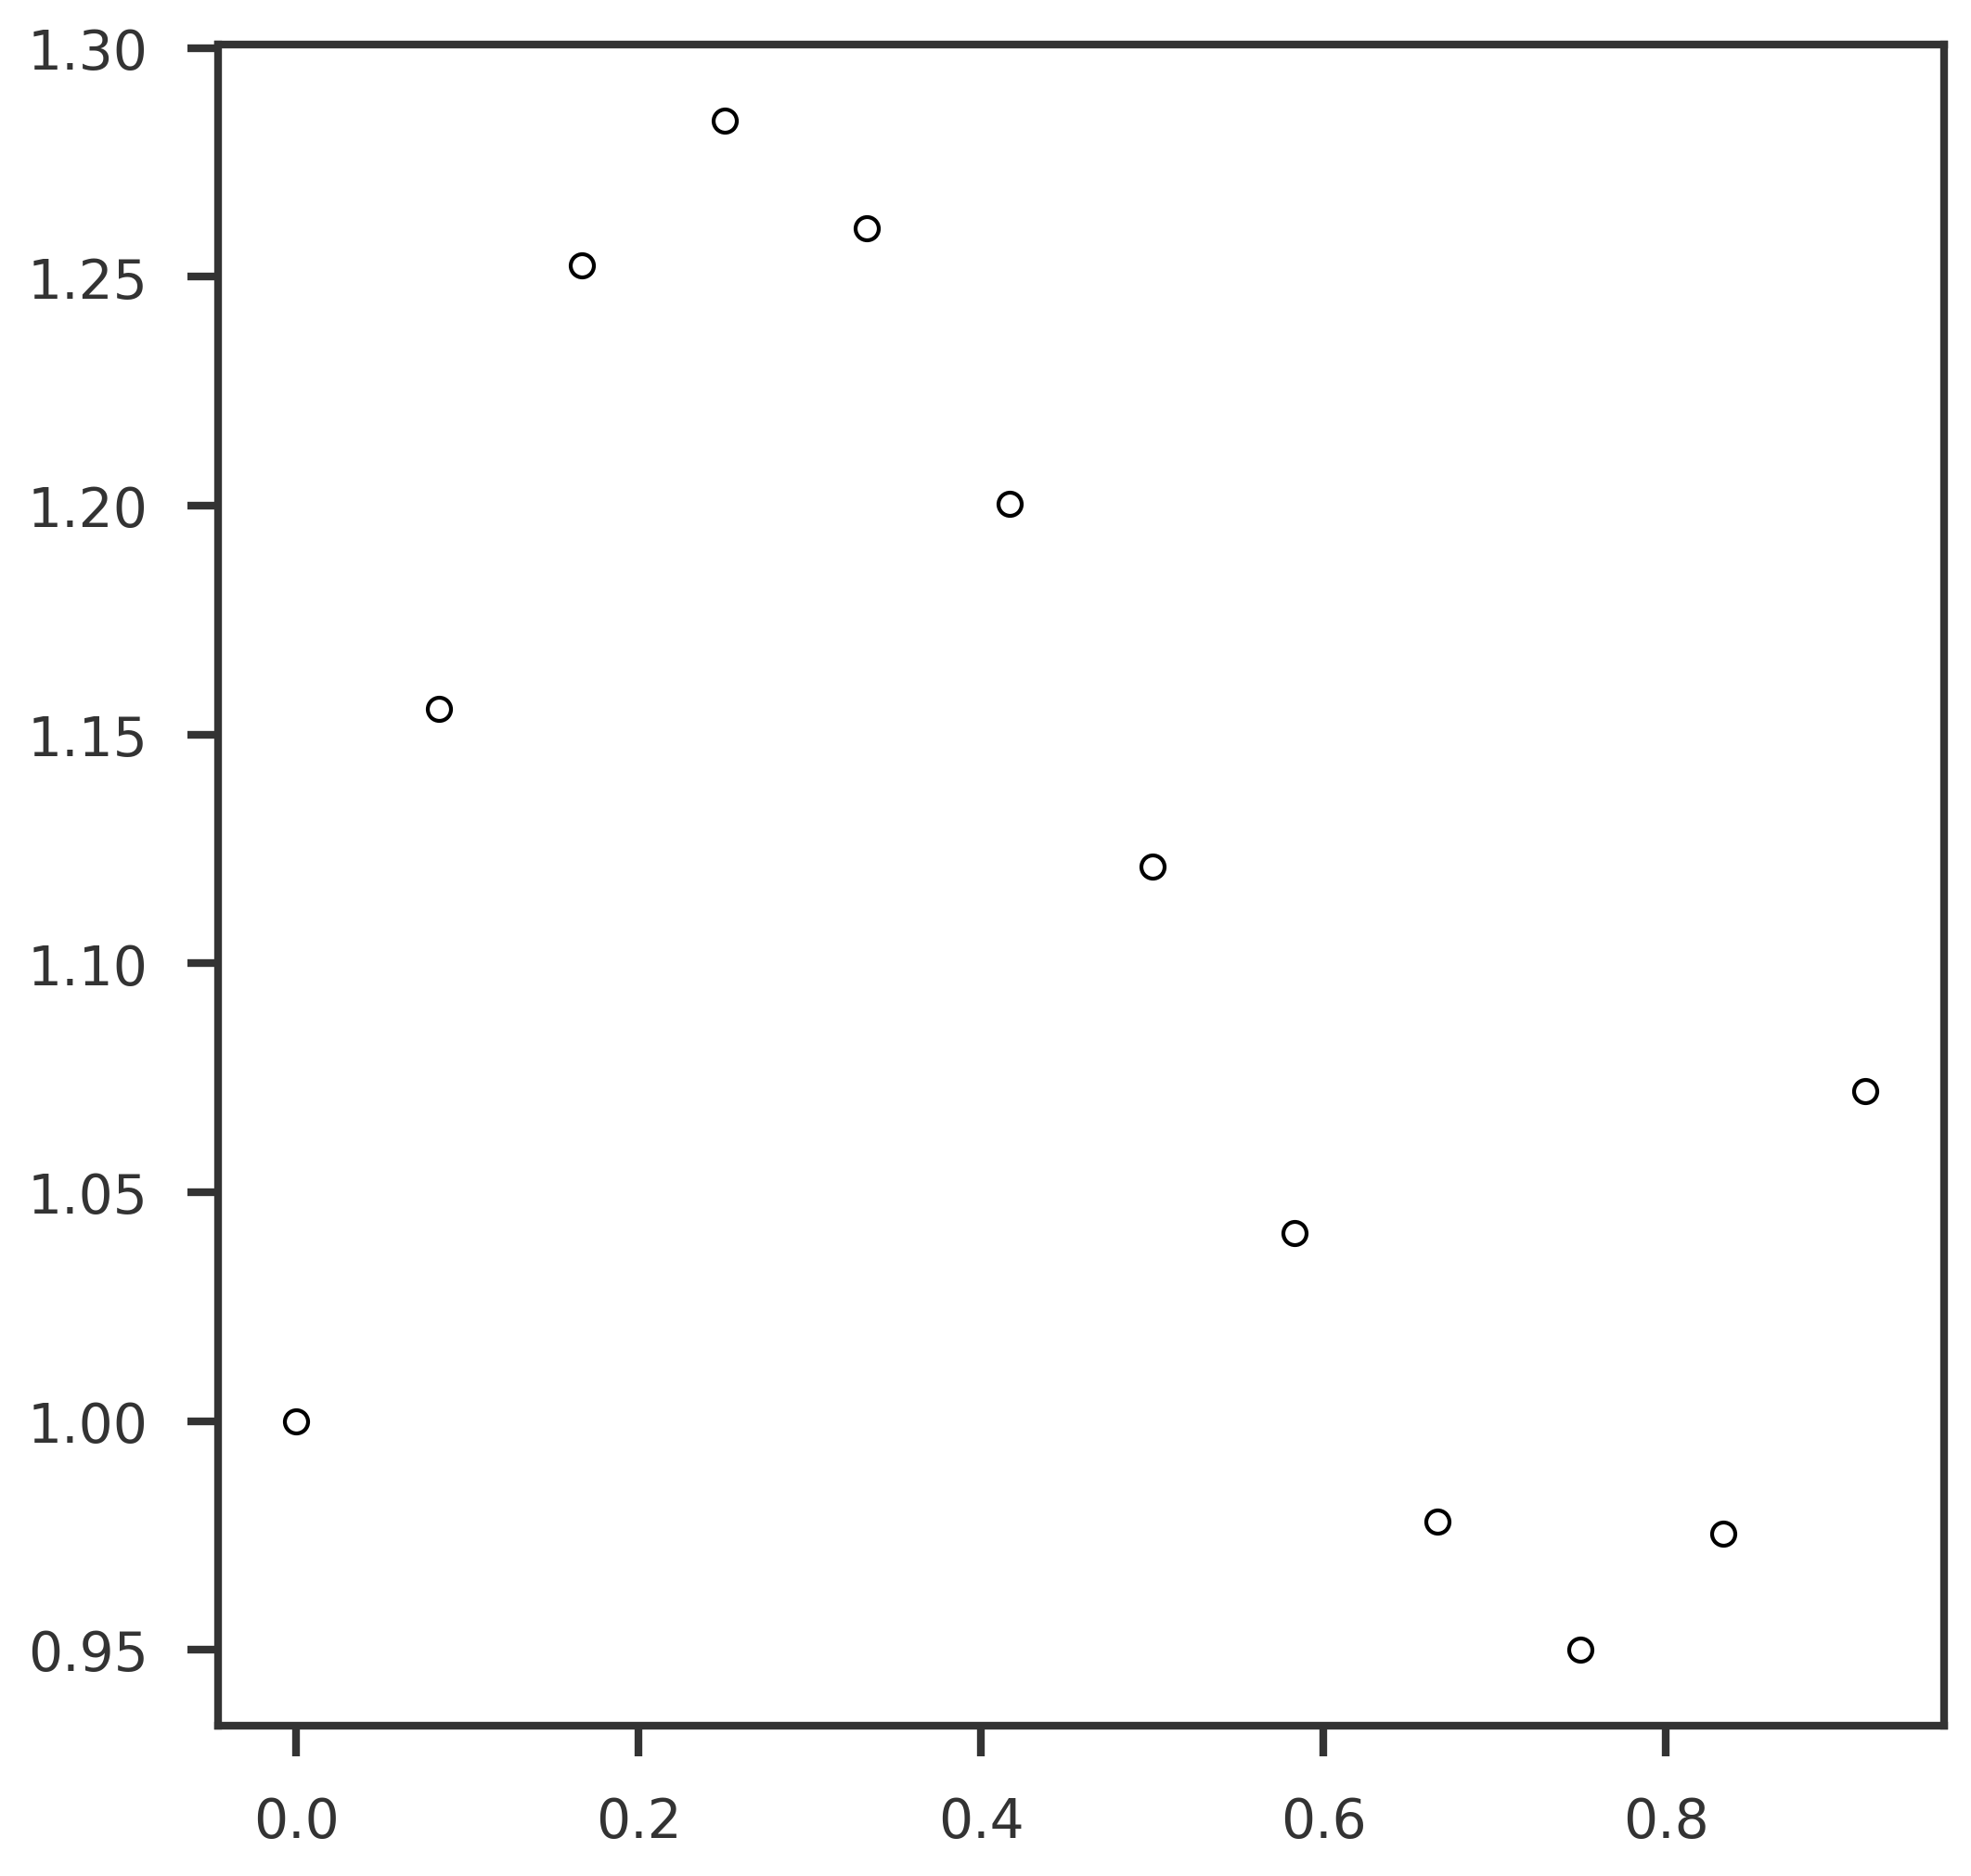

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

xvals = np.arange(n) / n
ax1.scatter(xvals, y, edgecolor = 'black', facecolor = 'white')
plt.show()

In [28]:
H

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 9.09090909e-02, 1.81818182e-01, 2.72727273e-01,
        3.63636364e-01, 4.54545455e-01, 5.45454545e-01, 6.36363636e-01,
        7.27272727e-01, 8.18181818e-01, 9.09090909e-01, 1.00000000e+00],
       [0.00000000e+00, 8.26446281e-03, 3.30578512e-02, 7.43801653e-02,
        1.32231405e-01, 2.06611570e-01, 2.97520661e-01, 4.04958678e-01,
        5.28925620e-01, 6.69421488e-01, 8.26446281e-01, 1.00000000e+00],
       [0.00000000e+00, 7.51314801e-04, 6.01051841e-03, 2.02854996e-02,
        4.80841473e-02, 9.39143501e-02, 1.62283997e-01, 2.57700977e-01,
        3.84673178e-01, 5.47708490e-01, 7.51314801e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.84673178e-04,
        4.38166792e-03, 1.64928625e-02, 4.12261458e-02, 8.30